Weblog lines

remotehost rfc931 authuser date "request" status bytes

* remotehost : Remote hostname (or IP number if DNS hostname is not available, or if DNSLookup is Off.
* rfc931 : The remote logname of the user.
* authuser : The username as which the user has authenticated himself
* date : Date and time of the request.
* “request” : The request line exactly as it came from the client.
* status : The HTTP status code returned to the client.
* bytes : The content-length of the document transferred.

Ensure that python versions and spark_home are correct

In [1]:
import os
os.environ["SPARK_HOME"] = "/home/azureuser/spark/spark-3.2.0-bin-hadoop3.2"
os.environ["PYSPARK_PYTHON"] = "/home/azureuser/miniconda3/envs/liten/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/azureuser/miniconda3/envs/liten/bin/python"

from platform import python_version
print(python_version())

3.8.5


Build or get a new litendata.com app with local one core master

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib
%matplotlib inline

spark = SparkSession.builder.master("local[1]") \
                    .appName('litendata.com') \
                    .getOrCreate()

Sample data and schema check

In [3]:
data = [("James","","Smith","36636","M",3000),
    ("Michael","Rose","","40288","M",4000),
    ("Robert","","Williams","42114","M",4000),
    ("Maria","Anne","Jones","39192","F",4000),
    ("Jen","Mary","Brown","","F",-1)
  ]

schema = StructType([ \
    StructField("firstname",StringType(),True), \
    StructField("middlename",StringType(),True), \
    StructField("lastname",StringType(),True), \
    StructField("id", StringType(), True), \
    StructField("gender", StringType(), True), \
    StructField("salary", IntegerType(), True) \
  ])
 
df = spark.createDataFrame(data=data,schema=schema)
df.printSchema()
df.show(n=10,truncate=False)


root
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: integer (nullable = true)

+---------+----------+--------+-----+------+------+
|firstname|middlename|lastname|id   |gender|salary|
+---------+----------+--------+-----+------+------+
|James    |          |Smith   |36636|M     |3000  |
|Michael  |Rose      |        |40288|M     |4000  |
|Robert   |          |Williams|42114|M     |4000  |
|Maria    |Anne      |Jones   |39192|F     |4000  |
|Jen      |Mary      |Brown   |     |F     |-1    |
+---------+----------+--------+-----+------+------+



Web log schema

In [4]:
weblog_schema = StructType([ \
    StructField("IP",StringType(),True), \
    StructField("Time",TimestampType(),True), \
    StructField("URL",StringType(),True), \
    StructField("Status", IntegerType(), True)
                           ])

Check with a simple weblog data

Read weblog from a file 

In [5]:
weblog_df = spark.read.format('csv').options(header='true').options(delimiter=',').options(timestampFormat='dd/MMM/yyyy:HH:mm:ss').schema(weblog_schema).load("/home/azureuser/github/dbaistuff/py/notebooks/weblog.csv")
weblog_df.printSchema()
weblog_df.take(5)

[Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 58, 55), URL='GET /login.php HTTP/1.1', Status=200),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 2), URL='POST /process.php HTTP/1.1', Status=302),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 3), URL='GET /home.php HTTP/1.1', Status=200),
 Row(IP='10.131.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 4), URL='GET /js/vendor/moment.min.js HTTP/1.1', Status=200),
 Row(IP='10.130.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 6), URL='GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1', Status=200)]

In [6]:
weblog_df.createOrReplaceTempView("weblog")
cntDf = spark.sql("select count(*) from weblog")
cntDf.show()

+--------+
|count(1)|
+--------+
|   16007|
+--------+



Get all redirection messages (3xx returns)

In [12]:
st3xxDf = spark.sql("SELECT Status, COUNT(*) FROM weblog WHERE Status LIKE '3%%' GROUP BY Status")
st3xxDf.show()

+------+--------+
|Status|count(1)|
+------+--------+
|   304|     658|
|   302|    3498|
+------+--------+



In [23]:
st17Df = spark.sql("SELECT * FROM weblog WHERE Time <= '2017-12-31'")
st17Df.take(2)

[Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 58, 55), URL='GET /login.php HTTP/1.1', Status=200),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 2), URL='POST /process.php HTTP/1.1', Status=302)]

<AxesSubplot:xlabel='Time'>

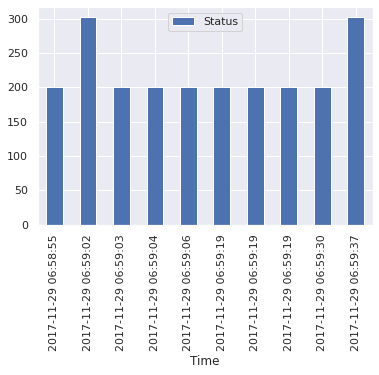

In [26]:
pandas_df = st17Df.toPandas()
pandas_df.iloc[:10].plot(x="Time",y="Status",kind='bar')